In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.16.5
pandas 0.25.2
sklearn 0.21.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

# 房价预测
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
# 划分样本
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test = train_test_split(housing.data,housing.target,random_state=7)
x_train,x_valid,y_train,y_valid = train_test_split(x_train_all,y_train_all,random_state=11)

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
# 归一化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [7]:
# RandomizedSearchCV
# 步骤
# 1. 转换为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers=1,layer_size=30,learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size,activation='relu',input_shape=x_train.shape[1:]))
    
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,activation='relu'))
        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse",optimizer=optimizer)
        
    return model

# 转成sklearn model
sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# 回调函数
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)]
# 训练
history = sklearn_model.fit(x_train_scaled,y_train,epochs=100,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 154us/sample - loss: 1.4658 - val_loss: 0.6868
Epoch 2/100
11610/11610 [==============================] - 1s 89us/sample - loss: 0.5832 - val_loss: 0.5775
Epoch 3/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.5226 - val_loss: 0.5310
Epoch 4/100
11610/11610 [==============================] - 1s 81us/sample - loss: 0.4935 - val_loss: 0.5075
Epoch 5/100
11610/11610 [==============================] - 1s 83us/sample - loss: 0.4734 - val_loss: 0.4901
Epoch 6/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4605 - val_loss: 0.4766
Epoch 7/100
11610/11610 [==============================] - 1s 81us/sample - loss: 0.4503 - val_loss: 0.4680
Epoch 8/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.4435 - val_loss: 0.4581
Epoch 9/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.43

11610/11610 [==============================] - 1s 76us/sample - loss: 0.3498 - val_loss: 0.3638
Epoch 76/100
11610/11610 [==============================] - 1s 76us/sample - loss: 0.3500 - val_loss: 0.3657
Epoch 77/100
11610/11610 [==============================] - 1s 82us/sample - loss: 0.3494 - val_loss: 0.3618
Epoch 78/100
11610/11610 [==============================] - 1s 81us/sample - loss: 0.3490 - val_loss: 0.3610
Epoch 79/100
11610/11610 [==============================] - 1s 81us/sample - loss: 0.3485 - val_loss: 0.3628


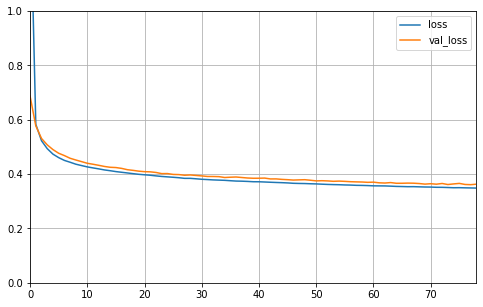

In [8]:
# 学习曲线
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)


In [12]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a<=x <=b
param_distribution = {
    "hidden_layers":[1,2,3,4],
    "layer_size":np.arange(1,100),
    "learning_rate":reciprocal(1e-4,1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,param_distribution,n_iter = 10,n_jobs=1)
random_search_cv.fit(x_train_scaled,y_train,epochs=100,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)
# cross_validation:训练集分成n份，n-1训练，最后一份验证

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 137us/sample - loss: 0.9943 - val_loss: 0.6166
Epoch 2/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.6359 - val_loss: 0.6136
Epoch 3/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.6297 - val_loss: 0.5102
Epoch 4/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.4761 - val_loss: 0.4701
Epoch 5/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4476 - val_loss: 0.4462
Epoch 6/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.4339 - val_loss: 0.4363
Epoch 7/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4168 - val_loss: 0.4186
Epoch 8/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4074 - val_loss: 0.4143
Epoch 9/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.3986 - val_loss: 0.40

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 136us/sample - loss: 1.1436 - val_loss: 0.7022
Epoch 2/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.7032 - val_loss: 0.5920
Epoch 3/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.7259 - val_loss: 0.5939
Epoch 4/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.6021 - val_loss: 0.5041
Epoch 5/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4656 - val_loss: 0.4717
Epoch 6/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4387 - val_loss: 0.4575
Epoch 7/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4206 - val_loss: 0.4336
Epoch 8/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4071 - val_loss: 0.4265
Epoch 9/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.3974 - val_loss: 0.41

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 130us/sample - loss: 1.4514 - val_loss: 0.6759
Epoch 2/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.5540 - val_loss: 0.5699
Epoch 3/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.5203 - val_loss: 0.5144
Epoch 4/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4759 - val_loss: 0.4790
Epoch 5/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4280 - val_loss: 0.4643
Epoch 6/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.4106 - val_loss: 0.4421
Epoch 7/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.3981 - val_loss: 0.4274
Epoch 8/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.3868 - val_loss: 0.4251
Epoch 9/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.3783 - val_loss: 0.

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 143us/sample - loss: 0.8952 - val_loss: 0.5906
Epoch 2/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.5867 - val_loss: 0.6784
Epoch 3/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.4804 - val_loss: 0.4696
Epoch 4/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4311 - val_loss: 0.4323
Epoch 5/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4080 - val_loss: 0.4152
Epoch 6/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.3941 - val_loss: 0.3998
Epoch 7/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.3830 - val_loss: 0.3854
Epoch 8/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3741 - val_loss: 0.3858
Epoch 9/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.3690 - val_loss: 0.3

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 142us/sample - loss: 1.0258 - val_loss: 0.7931
Epoch 2/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.8719 - val_loss: 0.5782
Epoch 3/100
7740/7740 [==============================] - 1s 103us/sample - loss: 0.5602 - val_loss: 0.4926
Epoch 4/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4699 - val_loss: 0.4576
Epoch 5/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.4445 - val_loss: 0.4486
Epoch 6/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.4029 - val_loss: 0.4129
Epoch 7/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.3903 - val_loss: 0.4153
Epoch 8/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.3795 - val_loss: 0.3905
Epoch 9/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.3705 - val_loss

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 143us/sample - loss: 1.2751 - val_loss: 0.6067
Epoch 2/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.5022 - val_loss: 0.4864
Epoch 3/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.4207 - val_loss: 0.4365
Epoch 4/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.3909 - val_loss: 0.4068
Epoch 5/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.3736 - val_loss: 0.3930
Epoch 6/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3613 - val_loss: 0.3837
Epoch 7/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.3527 - val_loss: 0.3802
Epoch 8/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3462 - val_loss: 0.3696
Epoch 9/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3384 - val_loss: 0

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 140us/sample - loss: 4.7274 - val_loss: 3.4140
Epoch 2/100
7740/7740 [==============================] - 1s 94us/sample - loss: 2.5683 - val_loss: 2.0415
Epoch 3/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.6480 - val_loss: 1.4039
Epoch 4/100
7740/7740 [==============================] - 1s 87us/sample - loss: 1.2016 - val_loss: 1.0906
Epoch 5/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.9744 - val_loss: 0.9329
Epoch 6/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.8552 - val_loss: 0.8504
Epoch 7/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.7895 - val_loss: 0.8041
Epoch 8/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.7506 - val_loss: 0.7762
Epoch 9/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.7258 - val_loss: 0.75

7740/7740 [==============================] - 1s 84us/sample - loss: 0.4835 - val_loss: 0.5059
Epoch 78/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.4824 - val_loss: 0.5046
Epoch 79/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.4814 - val_loss: 0.5033
Epoch 80/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.4805 - val_loss: 0.5025
Epoch 81/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.4795 - val_loss: 0.5016
Epoch 82/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.4785 - val_loss: 0.5006
Epoch 83/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.4775 - val_loss: 0.4995
Epoch 84/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.4766 - val_loss: 0.4984
Epoch 85/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.4757 - val_loss: 0.4973
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 126us/sample - loss: 3.3635 - val_loss: 2.4786
Epoch 2/100
7740/7740 [==============================] - 1s 91us/sample - loss: 1.9125 - val_loss: 1.5611
Epoch 3/100
7740/7740 [==============================] - 1s 86us/sample - loss: 1.3061 - val_loss: 1.1637
Epoch 4/100
7740/7740 [==============================] - 1s 82us/sample - loss: 1.0303 - val_loss: 0.9857
Epoch 5/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.8954 - val_loss: 0.8993
Epoch 6/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.8227 - val_loss: 0.8534
Epoch 7/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.7805 - val_loss: 0.8259
Epoch 8/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.7534 - val_loss: 0.8072
Epoch 9/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.7344 - val_loss: 0.79

7740/7740 [==============================] - 1s 91us/sample - loss: 0.4648 - val_loss: 0.4974
Epoch 78/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.4638 - val_loss: 0.4962
Epoch 79/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.4628 - val_loss: 0.4950
Epoch 80/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.4618 - val_loss: 0.4938
Epoch 81/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.4609 - val_loss: 0.4926
Epoch 82/100
7740/7740 [==============================] - 1s 80us/sample - loss: 0.4600 - val_loss: 0.4916
Epoch 83/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.4591 - val_loss: 0.4905
Epoch 84/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.4583 - val_loss: 0.4894
Epoch 85/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.4575 - val_loss: 0.4885
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 145us/sample - loss: 5.0352 - val_loss: 3.5488
Epoch 2/100
7740/7740 [==============================] - 1s 95us/sample - loss: 2.5206 - val_loss: 2.0940
Epoch 3/100
7740/7740 [==============================] - 1s 87us/sample - loss: 1.6098 - val_loss: 1.4979
Epoch 4/100
7740/7740 [==============================] - 1s 92us/sample - loss: 1.2012 - val_loss: 1.1952
Epoch 5/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.9892 - val_loss: 1.0239
Epoch 6/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.8672 - val_loss: 0.9206
Epoch 7/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.7934 - val_loss: 0.8557
Epoch 8/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.7469 - val_loss: 0.8152
Epoch 9/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.7171 - val_loss: 0.78

7740/7740 [==============================] - 1s 78us/sample - loss: 0.4621 - val_loss: 0.5132
Epoch 78/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.4608 - val_loss: 0.5118
Epoch 79/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.4596 - val_loss: 0.5103
Epoch 80/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.4585 - val_loss: 0.5090
Epoch 81/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.4573 - val_loss: 0.5076
Epoch 82/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.4562 - val_loss: 0.5063
Epoch 83/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.4551 - val_loss: 0.5048
Epoch 84/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.4540 - val_loss: 0.5036
Epoch 85/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.4530 - val_loss: 0.5024
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 143us/sample - loss: 4.3903 - val_loss: 3.0955
Epoch 2/100
7740/7740 [==============================] - 1s 103us/sample - loss: 2.1134 - val_loss: 1.5536
Epoch 3/100
7740/7740 [==============================] - 1s 98us/sample - loss: 1.1873 - val_loss: 1.0742
Epoch 4/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.9414 - val_loss: 0.9565
Epoch 5/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.8626 - val_loss: 0.8979
Epoch 6/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.8160 - val_loss: 0.8558
Epoch 7/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.7820 - val_loss: 0.8240
Epoch 8/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.7559 - val_loss: 0.7991
Epoch 9/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.7355 - val_loss: 0.7

7740/7740 [==============================] - 1s 94us/sample - loss: 0.4558 - val_loss: 0.4722
Epoch 78/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4546 - val_loss: 0.4708
Epoch 79/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4535 - val_loss: 0.4693
Epoch 80/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4521 - val_loss: 0.4682
Epoch 81/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4512 - val_loss: 0.4667
Epoch 82/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4501 - val_loss: 0.4653
Epoch 83/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4489 - val_loss: 0.4642
Epoch 84/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4480 - val_loss: 0.4629
Epoch 85/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4469 - val_loss: 0.4617
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 142us/sample - loss: 3.9709 - val_loss: 3.0282
Epoch 2/100
7740/7740 [==============================] - 1s 102us/sample - loss: 2.2804 - val_loss: 1.8340
Epoch 3/100
7740/7740 [==============================] - 1s 101us/sample - loss: 1.4737 - val_loss: 1.2816
Epoch 4/100
7740/7740 [==============================] - 1s 100us/sample - loss: 1.0976 - val_loss: 1.0314
Epoch 5/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.9176 - val_loss: 0.9080
Epoch 6/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.8240 - val_loss: 0.8420
Epoch 7/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.7710 - val_loss: 0.8052
Epoch 8/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.7387 - val_loss: 0.7822
Epoch 9/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.7174 - val_loss

7740/7740 [==============================] - 1s 95us/sample - loss: 0.4693 - val_loss: 0.5055
Epoch 78/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4680 - val_loss: 0.5038
Epoch 79/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4666 - val_loss: 0.5024
Epoch 80/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4653 - val_loss: 0.5008
Epoch 81/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4641 - val_loss: 0.4993
Epoch 82/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4629 - val_loss: 0.4980
Epoch 83/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4617 - val_loss: 0.4965
Epoch 84/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4606 - val_loss: 0.4952
Epoch 85/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4595 - val_loss: 0.4938
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 140us/sample - loss: 3.0877 - val_loss: 2.0369
Epoch 2/100
7740/7740 [==============================] - 1s 101us/sample - loss: 1.4512 - val_loss: 1.1794
Epoch 3/100
7740/7740 [==============================] - 1s 102us/sample - loss: 1.0135 - val_loss: 0.9783
Epoch 4/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.8877 - val_loss: 0.8987
Epoch 5/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.8207 - val_loss: 0.8483
Epoch 6/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.7743 - val_loss: 0.8116
Epoch 7/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.7396 - val_loss: 0.7831
Epoch 8/100
7740/7740 [==============================] - 1s 105us/sample - loss: 0.7121 - val_loss: 0.7598
Epoch 9/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.6895 - val_loss:

Epoch 77/100
7740/7740 [==============================] - 1s 110us/sample - loss: 0.4312 - val_loss: 0.4694
Epoch 78/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4301 - val_loss: 0.4679
Epoch 79/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.4290 - val_loss: 0.4669
Epoch 80/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.4279 - val_loss: 0.4655
Epoch 81/100
7740/7740 [==============================] - 1s 105us/sample - loss: 0.4269 - val_loss: 0.4645
Epoch 82/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.4259 - val_loss: 0.4634
Epoch 83/100
7740/7740 [==============================] - 1s 127us/sample - loss: 0.4248 - val_loss: 0.4618
Epoch 84/100
7740/7740 [==============================] - 1s 110us/sample - loss: 0.4239 - val_loss: 0.4608
Epoch 85/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4229 - val_loss: 0.4598
Epoch 86/100
7740/7740 [========

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 135us/sample - loss: 3.4510 - val_loss: 2.7168
Epoch 2/100
7740/7740 [==============================] - 1s 90us/sample - loss: 2.2765 - val_loss: 1.8041
Epoch 3/100
7740/7740 [==============================] - 1s 91us/sample - loss: 1.5984 - val_loss: 1.3368
Epoch 4/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.2446 - val_loss: 1.0999
Epoch 5/100
7740/7740 [==============================] - 1s 92us/sample - loss: 1.0549 - val_loss: 0.9703
Epoch 6/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.9431 - val_loss: 0.8914
Epoch 7/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.8738 - val_loss: 0.8405
Epoch 8/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.8275 - val_loss: 0.8057
Epoch 9/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.7949 - val_loss: 0.78

7740/7740 [==============================] - 1s 98us/sample - loss: 0.4704 - val_loss: 0.4821
Epoch 78/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.4693 - val_loss: 0.4809
Epoch 79/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4682 - val_loss: 0.4796
Epoch 80/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4671 - val_loss: 0.4784
Epoch 81/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4660 - val_loss: 0.4774
Epoch 82/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4651 - val_loss: 0.4761
Epoch 83/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4641 - val_loss: 0.4749
Epoch 84/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4631 - val_loss: 0.4738
Epoch 85/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.4622 - val_loss: 0.4726
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 159us/sample - loss: 5.2663 - val_loss: 4.3311
Epoch 2/100
7740/7740 [==============================] - 1s 97us/sample - loss: 3.4571 - val_loss: 2.9716
Epoch 3/100
7740/7740 [==============================] - 1s 83us/sample - loss: 2.4813 - val_loss: 2.1837
Epoch 4/100
7740/7740 [==============================] - 1s 91us/sample - loss: 1.9116 - val_loss: 1.7412
Epoch 5/100
7740/7740 [==============================] - 1s 92us/sample - loss: 1.5390 - val_loss: 1.4553
Epoch 6/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.2880 - val_loss: 1.2605
Epoch 7/100
7740/7740 [==============================] - 1s 97us/sample - loss: 1.1140 - val_loss: 1.1226
Epoch 8/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.9916 - val_loss: 1.0220
Epoch 9/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.9044 - val_loss: 0.9

7740/7740 [==============================] - 1s 95us/sample - loss: 0.4947 - val_loss: 0.5287
Epoch 78/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4937 - val_loss: 0.5276
Epoch 79/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4927 - val_loss: 0.5265
Epoch 80/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4917 - val_loss: 0.5255
Epoch 81/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.4908 - val_loss: 0.5245
Epoch 82/100
7740/7740 [==============================] - 1s 114us/sample - loss: 0.4898 - val_loss: 0.5235
Epoch 83/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.4890 - val_loss: 0.5225
Epoch 84/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.4881 - val_loss: 0.5215
Epoch 85/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.4872 - val_loss: 0.5205
Epoch 86/100
7740/7740 [=========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 142us/sample - loss: 4.0076 - val_loss: 3.3186
Epoch 2/100
7740/7740 [==============================] - 1s 90us/sample - loss: 2.4638 - val_loss: 2.1641
Epoch 3/100
7740/7740 [==============================] - 1s 96us/sample - loss: 1.6275 - val_loss: 1.5843
Epoch 4/100
7740/7740 [==============================] - 1s 94us/sample - loss: 1.2420 - val_loss: 1.3171
Epoch 5/100
7740/7740 [==============================] - 1s 85us/sample - loss: 1.0618 - val_loss: 1.1682
Epoch 6/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.9573 - val_loss: 1.0650
Epoch 7/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.8828 - val_loss: 0.9836
Epoch 8/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.8249 - val_loss: 0.9180
Epoch 9/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.7783 - val_loss: 0.86

7740/7740 [==============================] - 1s 100us/sample - loss: 0.4470 - val_loss: 0.4877
Epoch 78/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.4459 - val_loss: 0.4867
Epoch 79/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4451 - val_loss: 0.4855
Epoch 80/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4442 - val_loss: 0.4843
Epoch 81/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4432 - val_loss: 0.4833
Epoch 82/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4424 - val_loss: 0.4821
Epoch 83/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4416 - val_loss: 0.4811
Epoch 84/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.4408 - val_loss: 0.4800
Epoch 85/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.4399 - val_loss: 0.4789
Epoch 86/100
7740/7740 [========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 138us/sample - loss: 1.1108 - val_loss: 1.1006
Epoch 2/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.6424 - val_loss: 0.6095
Epoch 3/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.5574 - val_loss: 0.5613
Epoch 4/100
7740/7740 [==============================] - 1s 106us/sample - loss: 0.5145 - val_loss: 0.5191
Epoch 5/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.4794 - val_loss: 0.4838
Epoch 6/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4532 - val_loss: 0.4544
Epoch 7/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4338 - val_loss: 0.4377
Epoch 8/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4193 - val_loss: 0.4270
Epoch 9/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4089 - val_loss: 0.

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 158us/sample - loss: 1.2041 - val_loss: 0.6910
Epoch 2/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.5902 - val_loss: 0.6006
Epoch 3/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.5399 - val_loss: 0.5597
Epoch 4/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.5085 - val_loss: 0.5275
Epoch 5/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4867 - val_loss: 0.5040
Epoch 6/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4692 - val_loss: 0.4871
Epoch 7/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.4536 - val_loss: 0.4727
Epoch 8/100
7740/7740 [==============================] - 1s 106us/sample - loss: 0.4406 - val_loss: 0.4693
Epoch 9/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.4288 - val_loss: 0

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 157us/sample - loss: 1.0146 - val_loss: 0.7382
Epoch 2/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.6127 - val_loss: 0.6376
Epoch 3/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.5500 - val_loss: 0.5825
Epoch 4/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.5130 - val_loss: 0.5499
Epoch 5/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.4855 - val_loss: 0.5434
Epoch 6/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.4656 - val_loss: 0.5161
Epoch 7/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.4516 - val_loss: 0.4849
Epoch 8/100
7740/7740 [==============================] - 1s 99us/sample - loss: 0.4377 - val_loss: 0.4782
Epoch 9/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.4250 - val_loss: 0.45

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 127us/sample - loss: 2.4857 - val_loss: 1.4489
Epoch 2/100
7740/7740 [==============================] - 1s 95us/sample - loss: 1.3348 - val_loss: 1.3867
Epoch 3/100
7740/7740 [==============================] - 1s 84us/sample - loss: 1.3234 - val_loss: 1.3846
Epoch 4/100
7740/7740 [==============================] - 1s 78us/sample - loss: 1.3231 - val_loss: 1.3840
Epoch 5/100
7740/7740 [==============================] - 1s 89us/sample - loss: 1.3228 - val_loss: 1.3841
Epoch 6/100
7740/7740 [==============================] - 1s 88us/sample - loss: 1.3225 - val_loss: 1.3838
Epoch 7/100
7740/7740 [==============================] - 1s 84us/sample - loss: 1.3223 - val_loss: 1.3838
Epoch 8/100
7740/7740 [==============================] - 1s 82us/sample - loss: 1.3223 - val_loss: 1.3828
Epoch 9/100
7740/7740 [==============================] - 1s 84us/sample - loss: 1.3222 - val_loss: 1.38

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 133us/sample - loss: 2.4768 - val_loss: 1.3820
Epoch 2/100
7740/7740 [==============================] - 1s 79us/sample - loss: 1.2253 - val_loss: 1.2466
Epoch 3/100
7740/7740 [==============================] - 1s 78us/sample - loss: 1.1388 - val_loss: 1.1536
Epoch 4/100
7740/7740 [==============================] - 1s 77us/sample - loss: 1.0401 - val_loss: 1.0460
Epoch 5/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.9449 - val_loss: 0.9535
Epoch 6/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.8621 - val_loss: 0.8660
Epoch 7/100
7740/7740 [==============================] - 1s 81us/sample - loss: 0.7809 - val_loss: 0.7908
Epoch 8/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.7102 - val_loss: 0.7286
Epoch 9/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.6562 - val_loss: 0.68

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 135us/sample - loss: 2.1964 - val_loss: 1.2505
Epoch 2/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.8377 - val_loss: 0.6894
Epoch 3/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.6070 - val_loss: 0.6450
Epoch 4/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.5754 - val_loss: 0.6171
Epoch 5/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.5497 - val_loss: 0.5873
Epoch 6/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.5253 - val_loss: 0.5619
Epoch 7/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.5027 - val_loss: 0.5398
Epoch 8/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.4850 - val_loss: 0.5229
Epoch 9/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.4703 - val_loss: 0.50

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 128us/sample - loss: 2.7929 - val_loss: 1.0667
Epoch 2/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.9842 - val_loss: 0.7335
Epoch 3/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.6758 - val_loss: 0.6905
Epoch 4/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.6433 - val_loss: 0.6648
Epoch 5/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.6214 - val_loss: 0.6429
Epoch 6/100
7740/7740 [==============================] - 1s 81us/sample - loss: 0.6028 - val_loss: 0.6261
Epoch 7/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.5850 - val_loss: 0.6070
Epoch 8/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.5704 - val_loss: 0.5915
Epoch 9/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.5573 - val_loss: 0.57

7740/7740 [==============================] - 1s 86us/sample - loss: 0.3905 - val_loss: 0.4024
Epoch 78/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.3899 - val_loss: 0.4022
Epoch 79/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3890 - val_loss: 0.4012
Epoch 80/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.3882 - val_loss: 0.4007
Epoch 81/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.3873 - val_loss: 0.3997
Epoch 82/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.3870 - val_loss: 0.3991
Epoch 83/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3863 - val_loss: 0.3984
Epoch 84/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.3854 - val_loss: 0.3974
Epoch 85/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.3847 - val_loss: 0.3959
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 149us/sample - loss: 2.3407 - val_loss: 1.1894
Epoch 2/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.8428 - val_loss: 0.7964
Epoch 3/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.7059 - val_loss: 0.7420
Epoch 4/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.6616 - val_loss: 0.7053
Epoch 5/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.6294 - val_loss: 0.6748
Epoch 6/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.6030 - val_loss: 0.6476
Epoch 7/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.5805 - val_loss: 0.6269
Epoch 8/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.5610 - val_loss: 0.6061
Epoch 9/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.5436 - val_loss: 0.58

7740/7740 [==============================] - 1s 87us/sample - loss: 0.3813 - val_loss: 0.4008
Epoch 78/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.3808 - val_loss: 0.4001
Epoch 79/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3801 - val_loss: 0.3990
Epoch 80/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.3793 - val_loss: 0.3984
Epoch 81/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.3790 - val_loss: 0.3978
Epoch 82/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.3783 - val_loss: 0.3974
Epoch 83/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3778 - val_loss: 0.3965
Epoch 84/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3770 - val_loss: 0.3968
Epoch 85/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.3766 - val_loss: 0.3955
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 120us/sample - loss: 1.9366 - val_loss: 1.0040
Epoch 2/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.7996 - val_loss: 0.8122
Epoch 3/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.7060 - val_loss: 0.7589
Epoch 4/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.6623 - val_loss: 0.7228
Epoch 5/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.6280 - val_loss: 0.6887
Epoch 6/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.6005 - val_loss: 0.6601
Epoch 7/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.5763 - val_loss: 0.6358
Epoch 8/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.5540 - val_loss: 0.6123
Epoch 9/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.5361 - val_loss: 0.59

7740/7740 [==============================] - 1s 84us/sample - loss: 0.3668 - val_loss: 0.4032
Epoch 78/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3668 - val_loss: 0.4017
Epoch 79/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.3666 - val_loss: 0.4001
Epoch 80/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.3655 - val_loss: 0.4001
Epoch 81/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.3643 - val_loss: 0.3979
Epoch 82/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.3647 - val_loss: 0.3972
Epoch 83/100
7740/7740 [==============================] - 1s 81us/sample - loss: 0.3639 - val_loss: 0.3978
Epoch 84/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3629 - val_loss: 0.3960
Epoch 85/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3619 - val_loss: 0.3948
Epoch 86/100
7740/7740 [==========================

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 126us/sample - loss: 0.9145 - val_loss: 0.6814
Epoch 2/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.6463 - val_loss: 0.6046
Epoch 3/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.5738 - val_loss: 0.5424
Epoch 4/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.5574 - val_loss: 0.5108
Epoch 5/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.4730 - val_loss: 0.4840
Epoch 6/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.4520 - val_loss: 0.4641
Epoch 7/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.4426 - val_loss: 0.4540
Epoch 8/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.4334 - val_loss: 0.4666
Epoch 9/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.4250 - val_loss: 0.43

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 125us/sample - loss: 1.1854 - val_loss: 0.8554
Epoch 2/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.8097 - val_loss: 0.8507
Epoch 3/100
7740/7740 [==============================] - 1s 94us/sample - loss: 1.2096 - val_loss: 0.5401
Epoch 4/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.5133 - val_loss: 0.4991
Epoch 5/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.4559 - val_loss: 0.4743
Epoch 6/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4390 - val_loss: 0.4538
Epoch 7/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4267 - val_loss: 0.4404
Epoch 8/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.4197 - val_loss: 0.4366
Epoch 9/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.4120 - val_loss: 0.43

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 143us/sample - loss: 1.0325 - val_loss: 0.6866
Epoch 2/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.5814 - val_loss: 0.5603
Epoch 3/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.4856 - val_loss: 0.5096
Epoch 4/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4563 - val_loss: 0.4870
Epoch 5/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.4401 - val_loss: 0.4712
Epoch 6/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.4271 - val_loss: 0.4541
Epoch 7/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.4166 - val_loss: 0.4447
Epoch 8/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.4101 - val_loss: 0.4367
Epoch 9/100
7740/7740 [==============================] - 1s 86us/sample - loss: 0.4011 - val_loss: 0.43

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 150us/sample - loss: 0.8597 - val_loss: 0.6105
Epoch 2/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.6620 - val_loss: 0.5770
Epoch 3/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.4856 - val_loss: 0.4664
Epoch 4/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4218 - val_loss: 0.4211
Epoch 5/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.3972 - val_loss: 0.4066
Epoch 6/100
7740/7740 [==============================] - 1s 101us/sample - loss: 0.3839 - val_loss: 0.3861
Epoch 7/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.3730 - val_loss: 0.3804
Epoch 8/100
7740/7740 [==============================] - 1s 94us/sample - loss: 0.3656 - val_loss: 0.3745
Epoch 9/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.3606 - val_loss: 

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 151us/sample - loss: 0.8979 - val_loss: 0.5901
Epoch 2/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.5212 - val_loss: 0.5043
Epoch 3/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.4392 - val_loss: 0.4449
Epoch 4/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.4052 - val_loss: 0.4085
Epoch 5/100
7740/7740 [==============================] - 1s 95us/sample - loss: 0.3865 - val_loss: 0.4026
Epoch 6/100
7740/7740 [==============================] - 1s 91us/sample - loss: 0.3789 - val_loss: 0.4028
Epoch 7/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.3696 - val_loss: 0.3776
Epoch 8/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.3622 - val_loss: 0.3781
Epoch 9/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.3573 - val_loss: 0.3

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 165us/sample - loss: 0.8427 - val_loss: 0.5827
Epoch 2/100
7740/7740 [==============================] - 1s 103us/sample - loss: 0.4813 - val_loss: 0.4935
Epoch 3/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.4243 - val_loss: 0.4522
Epoch 4/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.4045 - val_loss: 0.4325
Epoch 5/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.3823 - val_loss: 0.4007
Epoch 6/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.3734 - val_loss: 0.3988
Epoch 7/100
7740/7740 [==============================] - 1s 93us/sample - loss: 0.3669 - val_loss: 0.3842
Epoch 8/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.3584 - val_loss: 0.3823
Epoch 9/100
7740/7740 [==============================] - 1s 96us/sample - loss: 0.3516 - val_loss: 0

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 120us/sample - loss: 1.0390 - val_loss: 0.5125
Epoch 2/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4591 - val_loss: 0.4626
Epoch 3/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.4241 - val_loss: 0.4306
Epoch 4/100
11610/11610 [==============================] - 1s 80us/sample - loss: 0.4045 - val_loss: 0.4065
Epoch 5/100
11610/11610 [==============================] - 1s 78us/sample - loss: 0.3867 - val_loss: 0.3911
Epoch 6/100
11610/11610 [==============================] - 1s 76us/sample - loss: 0.3748 - val_loss: 0.3887
Epoch 7/100
11610/11610 [==============================] - 1s 79us/sample - loss: 0.3674 - val_loss: 0.3744
Epoch 8/100
11610/11610 [==============================] - 1s 85us/sample - loss: 0.3634 - val_loss: 0.3660
Epoch 9/100
11610/11610 [==============================] - 1s 82us/sample - loss: 0.35

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001ACFB198648>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AD836AF0C8>},
                   pre_dispatch='2*n_jobs', random_state=None, r

In [13]:
# 查询最好参数、分值、模型
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 2, 'layer_size': 44, 'learning_rate': 0.007739691829708417}
-0.31282472871532735


In [14]:
# 获取最好模型，对测试集进行测试
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled,y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.31199741520622903